# AutoInland Vehicle Insurance Claim Challenge StarterNotebook - Python

This is a simple starter notebook to get started with the AutoInland Vehicle Insurance Claim Challenge on Zindi.

This notebook covers:
- Loading the data
- Simple EDA and an example of feature enginnering
- Data preprocessing and data wrangling
- Creating a simple model
- Making a submission
- Some tips for improving your score

### Importing libraries

In [82]:
import pandas as pd
import numpy as np
import datetime as dt
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.experimental import enable_iterative_imputer  
from sklearn.impute import IterativeImputer
from sklearn.impute import KNNImputer

import warnings
warnings.filterwarnings('ignore')

### Read files

In [83]:
# Load files into a pandas dataframe
train = pd.read_csv('./csv files/Train.csv')
test = pd.read_csv('./csv files/Test.csv')
ss = pd.read_csv('./csv files/SampleSubmission.csv')

## Eploratory Data Analysis

In [84]:
# Preview the first five rows of the train set
train.head()

,ID,Policy_Start_Date,Policy_End_Date,Gender,Age,First_Transaction_Date,No_Pol,Car_Category,Subject_Car_Colour,Subject_Car_Make,LGA_Name,State,ProductName,target
0,ID_0040R73,2010-05-14,2011-05-13,Male,30,2010-05-14,1,Saloon,Black,TOYOTA,NaN,NaN,Car Classic,0
1,ID_0046BNK,2010-11-29,2011-11-28,Female,79,2010-11-29,1,JEEP,Grey,TOYOTA,NaN,NaN,Car Classic,1
2,ID_005QMC3,2010-03-21,2011-03-20,Male,43,2010-03-21,1,Saloon,Red,TOYOTA,NaN,NaN,Car Classic,0
3,ID_0079OHW,2010-08-21,2011-08-20,Male,2,2010-08-21,1,NaN,NaN,NaN,NaN,NaN,CarSafe,0
4,ID_00BRP63,2010-08-29,2010-12-31,Entity,20,2010-08-29,3,NaN,NaN,NaN,Lagos,Lagos,Muuve,1


In [85]:
# Preview the first five rows of the test set
test.head()

,ID,Policy_Start_Date,Policy_End_Date,Gender,Age,First_Transaction_Date,No_Pol,Car_Category,Subject_Car_Colour,Subject_Car_Make,LGA_Name,State,ProductName
0,ID_01QM0NU,2010-10-23,2011-10-22,Female,46,2010-10-23,1,NaN,NaN,Ford,Abuja Municipal,Abuja-Municipal,Car Classic
1,ID_024NJLZ,2010-10-14,2011-10-13,Male,32,2010-10-14,1,NaN,NaN,NaN,Kosofe,Benue,Car Classic
2,ID_02NOVWQ,2010-08-29,2011-08-28,Female,45,2010-08-29,2,Saloon,Black,Honda,Wuse 11,Abuja,Car Classic
3,ID_02VSP68,2010-06-13,2011-06-12,Female,58,2010-06-13,1,Saloon,NaN,TOYOTA,NaN,NaN,CarSafe
4,ID_02YB37K,2010-07-01,2011-06-30,NaN,120,2010-07-01,1,Saloon,Red,Hyundai,Victoria Island,Lagos,Car Classic


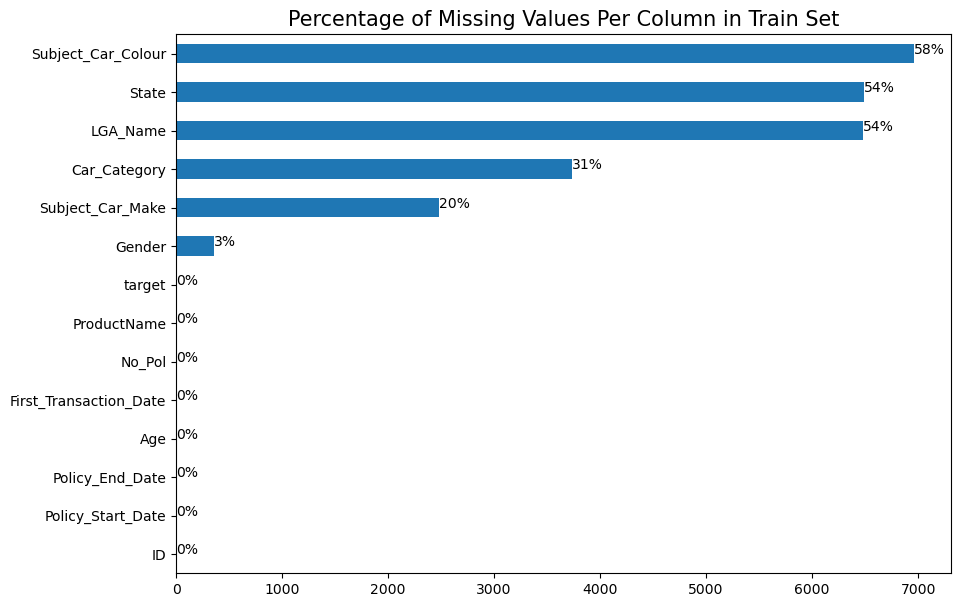

In [86]:
# Check if there any missing values in train set
ax = train.isna().sum().sort_values().plot(kind = 'barh', figsize = (10, 7))
plt.title('Percentage of Missing Values Per Column in Train Set', fontdict={'size':15})
for p in ax.patches:
    percentage ='{:,.0f}%'.format((p.get_width()/train.shape[0])*100)
    width, height =p.get_width(),p.get_height()
    x=p.get_x()+width+0.02
    y=p.get_y()+height/2
    ax.annotate(percentage,(x,y))

## Cleaning Data

In [87]:
mapper = {'Entity':'Other', 'Joint Gender':'Other', 'NOT STATED':'Other', 'NO GENDER': 'Other', 'SEX':"Other"}
train.Gender = train.Gender.replace(mapper)

# Confirm mappings
train.Gender.value_counts()

Gender
Male      7617
Female    3327
Other      776
Name: count, dtype: int64

### Adding other gender to "Other"

In [88]:
mapper = {'Entity':'Other', 'Joint Gender':'Other', 'NOT STATED':'Other', 'NO GENDER': 'Other', 'SEX':"Other"}
test.Gender = test.Gender.replace(mapper)

# Confirm mappings
test.Gender.value_counts()

Gender
Male      739
Female    352
Other      70
Name: count, dtype: int64

### Change Dates

In [89]:
train["Policy_Start_Date"] = pd.to_datetime(train["Policy_Start_Date"])
train["Policy_Start_Year"] = train["Policy_Start_Date"].dt.year
train["Policy_Start_Month"] = train["Policy_Start_Date"].dt.month
train["Policy_Start_Day"] = train["Policy_Start_Date"].dt.day

In [90]:
train["Policy_End_Date"] = pd.to_datetime(train["Policy_End_Date"])
train["Policy_End_Year"] = train["Policy_End_Date"].dt.year
train["Policy_End_Month"] = train["Policy_End_Date"].dt.month
train["Policy_End_Day"] = train["Policy_End_Date"].dt.day

In [91]:
train["First_Transaction_Date"] = pd.to_datetime(train["First_Transaction_Date"])
train["First_Transaction_Year"] = train["First_Transaction_Date"].dt.year
train["First_Transaction_Month"] = train["First_Transaction_Date"].dt.year
train["First_Transaction_Day"] = train["First_Transaction_Date"].dt.year


In [41]:
train = train.drop(["Policy Start Date", "Policy End Date", "First Transaction Date"], axis=1)

In [92]:
test["Policy_Start_Date"] = pd.to_datetime(test["Policy_Start_Date"])
test["Policy_Start_Year"] = test["Policy_Start_Date"].dt.year
test["Policy_Start_Month"] = test["Policy_Start_Date"].dt.month
test["Policy_Start_Day"] = test["Policy_Start_Date"].dt.day

In [93]:
test["Policy_End_Date"] = pd.to_datetime(test["Policy_End_Date"])
test["Policy_End_Year"] = test["Policy_End_Date"].dt.year
test["Policy_End_Month"] = test["Policy_End_Date"].dt.month
test["Policy_End_Day"] = test["Policy_End_Date"].dt.day

In [94]:
test["First_Transaction_Date"] = pd.to_datetime(test["First_Transaction_Date"])
test["First_Transaction_Year"] = test["First_Transaction_Date"].dt.year
test["First_Transaction_Month"] = test["First_Transaction_Date"].dt.year
test["First_Transaction_Day"] = test["First_Transaction_Date"].dt.year

In [46]:
test = test.drop(["Policy Start Date", "Policy End Date", "First Transaction Date"], axis=1)

In [47]:
target = "target"
train = train [[col for col in train.columns if col != target] + [target]]

In [66]:
train.head()

,ID,Policy Start Date,Policy End Date,Gender,Age,First Transaction Date,No_Pol,Car_Category,Subject_Car_Colour,Subject_Car_Make,...,target,Policy Start Year,Policy Start Month,Policy Start Day,Policy End Year,Policy End Month,Policy End Day,First Transaction Year,First Transaction Month,First Transaction Day
0,ID_0040R73,2010-05-14,2011-05-13,Male,30,2010-05-14,1,Saloon,Black,TOYOTA,...,0,2010,5,14,2011,5,13,2010,2010,2010
1,ID_0046BNK,2010-11-29,2011-11-28,Female,79,2010-11-29,1,JEEP,Grey,TOYOTA,...,1,2010,11,29,2011,11,28,2010,2010,2010
2,ID_005QMC3,2010-03-21,2011-03-20,Male,43,2010-03-21,1,Saloon,Red,TOYOTA,...,0,2010,3,21,2011,3,20,2010,2010,2010
3,ID_0079OHW,2010-08-21,2011-08-20,Male,2,2010-08-21,1,NaN,NaN,NaN,...,0,2010,8,21,2011,8,20,2010,2010,2010
4,ID_00BRP63,2010-08-29,2010-12-31,Other,20,2010-08-29,3,NaN,NaN,NaN,...,1,2010,8,29,2010,12,31,2010,2010,2010


### Sorting the date

In [95]:
train = train.sort_values(by='Policy_Start_Date')

### Using Front_fill method

In [97]:
def front_fill_data(data, columns):
    for column in columns:
        data[column] = data[column].fillna(method='ffill')
    return data

backfill_columns = ['Car_Category', 'Subject_Car_Colour', 'Subject_Car_Make', 'LGA_Name', 'State']

backfilled_data = front_fill_data(train, backfill_columns)

print("Original Data:")
print(train)
print("\nBackfilled Data:")
print(backfilled_data)
backfilled_data.to_csv('front_filled_data.csv', index=False)

Original Data:
               ID Policy_Start_Date Policy_End_Date  Gender  Age  \
8010   ID_O51ZQ1B        2001-12-11      2011-12-10  Female   37   
10526  ID_VJ1FAVO        2002-03-25      2011-03-24    Male   37   
10234  ID_ULWS8VL        2003-04-13      2011-04-12    Male   41   
12066  ID_ZYKGSP7        2003-12-21      2034-05-20    Male   48   
8124   ID_OEWBKGF        2005-08-05      2011-09-29  Female   44   
...           ...               ...             ...     ...  ...   
7479   ID_MLGO8DZ        2010-12-31      2011-06-30    Male   51   
1997   ID_62LBOWI        2010-12-31      2011-12-30    Male   44   
11299  ID_XR8F115        2010-12-31      2011-12-30    Male   37   
2919   ID_8P2UGYO        2010-12-31      2011-12-30    Male   20   
2886   ID_8MNXRC6        2010-12-31      2011-12-16    Male   36   

      First_Transaction_Date  No_Pol Car_Category Subject_Car_Colour  \
8010              2001-12-11       1       Saloon              Black   
10526             2002-0

### Using mode based imputation on gender**

In [98]:
train['Gender'] = train['Gender'].fillna(train['Gender'].mode()[0])

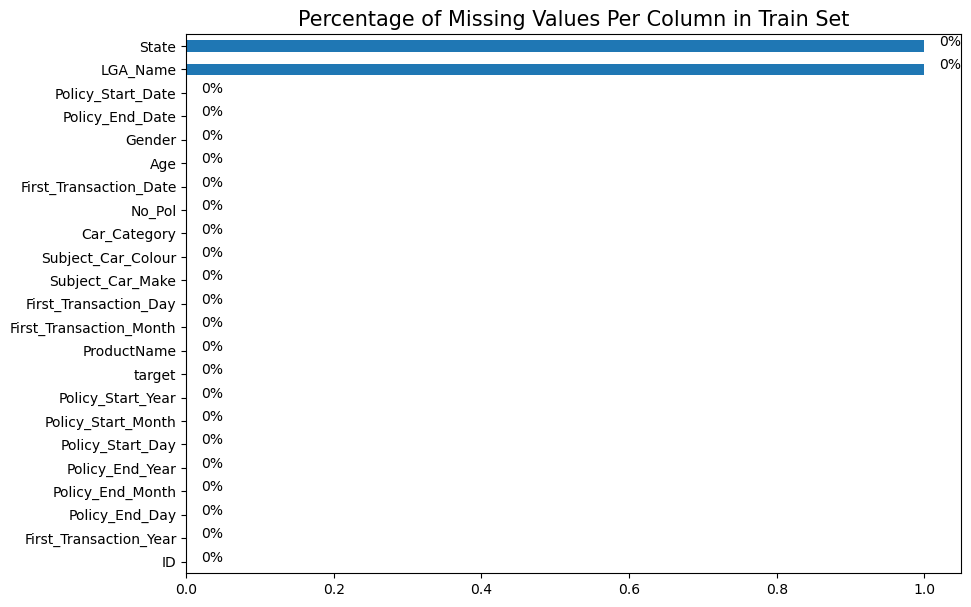

In [99]:
ax = train.isna().sum().sort_values().plot(kind = 'barh', figsize = (10, 7))
plt.title('Percentage of Missing Values Per Column in Train Set', fontdict={'size':15})
for p in ax.patches:
    percentage ='{:,.0f}%'.format((p.get_width()/train.shape[0])*100)
    width, height =p.get_width(),p.get_height()
    x=p.get_x()+width+0.02
    y=p.get_y()+height/2
    ax.annotate(percentage,(x,y))

## Combine train and test set for easy preprocessing 

In [17]:
# Combine train and test set
ntrain = train.shape[0] # to be used to split train and test set from the combined dataframe

all_data = pd.concat((train, test)).reset_index(drop=True)
print(f'The shape of the combined dataframe is: {all_data.shape}')

The shape of the combined dataframe is: (13281, 14)


In [18]:
# Preview the last five rows of the combined dataframe
all_data.tail()

,ID,Policy Start Date,Policy End Date,Gender,Age,First Transaction Date,No_Pol,Car_Category,Subject_Car_Colour,Subject_Car_Make,LGA_Name,State,ProductName,target
13276,ID_ZTTHC5X,2010-12-05,2011-12-04,Male,67,2010-12-05,2,JEEP,Black,TOYOTA,Victoria Island,Lagos,Car Classic,NaN
13277,ID_ZUJAFUP,2010-01-14,2011-01-13,Male,43,2010-01-14,1,Saloon,Silver,Hyundai,Surulere,Lagos,Car Classic,NaN
13278,ID_ZWHCTUM,2010-07-26,2011-07-25,Male,30,2010-07-26,1,Truck,White,Iveco,Victoria Island,Lagos,CVTP,NaN
13279,ID_ZWQRL8L,2010-02-16,2011-02-15,Male,44,2010-02-16,2,Saloon,NaN,Nissan,Aba North,Aba-North,Car Classic,NaN
13280,ID_ZWZ92GU,2010-03-18,2011-03-17,Male,28,2010-03-18,1,Saloon,Silver,TOYOTA,NaN,NaN,Car Classic,NaN


In [20]:
# Check the column names and datatypes
all_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13281 entries, 0 to 13280
Data columns (total 14 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   ID                      13281 non-null  object 
 1   Policy Start Date       13281 non-null  object 
 2   Policy End Date         13281 non-null  object 
 3   Gender                  12881 non-null  object 
 4   Age                     13281 non-null  int64  
 5   First Transaction Date  13281 non-null  object 
 6   No_Pol                  13281 non-null  int64  
 7   Car_Category            9171 non-null   object 
 8   Subject_Car_Colour      5622 non-null   object 
 9   Subject_Car_Make        10557 non-null  object 
 10  LGA_Name                6149 non-null   object 
 11  State                   6137 non-null   object 
 12  ProductName             13281 non-null  object 
 13  target                  12079 non-null  float64
dtypes: float64(1), int64(2), object(11)
me

In [21]:
# Change each column to its appriopriate datatype
date_cols = [col for col in all_data.columns if 'Date' in col]
num_cols = ['Age', 'No_Pol']
cat_cols = [col for col in all_data.columns if col not in date_cols+num_cols+['ID', 'target']]

for col in all_data.columns:
  if col in date_cols:
    all_data[col] = pd.to_datetime(all_data[col])
  elif col in cat_cols:
    all_data[col] = all_data[col].astype('category')

# Confirm whether the changes have been applied successfully
all_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13281 entries, 0 to 13280
Data columns (total 14 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   ID                      13281 non-null  object        
 1   Policy Start Date       13281 non-null  datetime64[ns]
 2   Policy End Date         13281 non-null  datetime64[ns]
 3   Gender                  12881 non-null  category      
 4   Age                     13281 non-null  int64         
 5   First Transaction Date  13281 non-null  datetime64[ns]
 6   No_Pol                  13281 non-null  int64         
 7   Car_Category            9171 non-null   category      
 8   Subject_Car_Colour      5622 non-null   category      
 9   Subject_Car_Make        10557 non-null  category      
 10  LGA_Name                6149 non-null   category      
 11  State                   6137 non-null   category      
 12  ProductName             13281 non-null  catego

### Distribution of the target variable

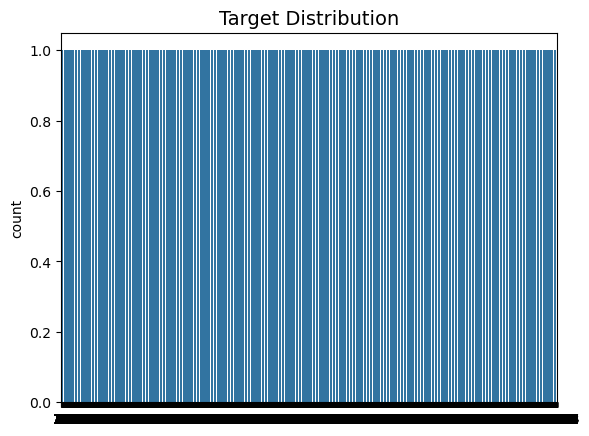

In [22]:
sns.countplot(train.target)
plt.title('Target Distribution', fontdict={'size':14});

### Distribution of the Gender column

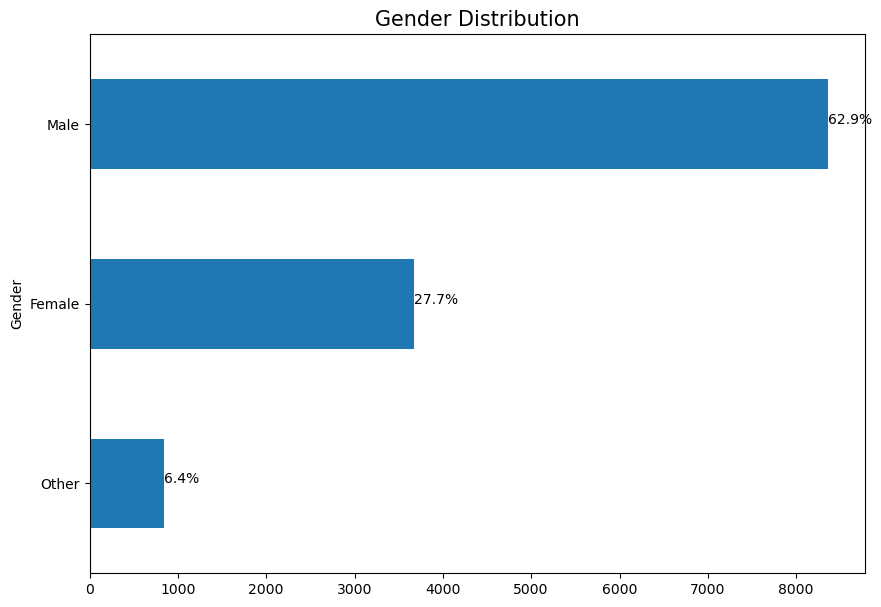

In [25]:
# Gender distribution 
ax = all_data.Gender.value_counts().sort_values().plot(kind = 'barh', figsize=(10,7))
plt.title('Gender Distribution', fontdict={'size': 15})
for p in ax.patches:
  percentage ='{:,.1f}%'.format((p.get_width()/all_data.shape[0])*100)
  width, height =p.get_width(),p.get_height()
  x=p.get_x()+width+0.02
  y=p.get_y()+height/2
  ax.annotate(percentage,(x,y))

In [24]:
mapper = {'Entity':'Other', 'Joint Gender':'Other', 'NOT STATED':'Other', 'NO GENDER': 'Other', 'SEX':"Other"}
all_data.Gender = all_data.Gender.replace(mapper)

# Confirm mappings
all_data.Gender.value_counts()

Gender
Male      8356
Female    3679
Other      846
Name: count, dtype: int64

### Number of unique values per categorical column

In [26]:
# Check unique values for each categorical column
for col in cat_cols:
  print(col)
  print(all_data[col].unique(), '\n')

Gender
['Male', 'Female', 'Other', NaN]
Categories (3, object): ['Other', 'Female', 'Male'] 

Car_Category
['Saloon', 'JEEP', NaN, 'Motorcycle', 'Truck', ..., 'Wagon', 'Shape Of Vehicle Chasis', 'Sedan', 'Station 4 Wheel', 'Tipper Truck']
Length: 17
Categories (16, object): ['Bus', 'CAMRY CAR HIRE', 'JEEP', 'Mini Bus', ..., 'Tipper Truck', 'Truck', 'Van', 'Wagon'] 

Subject_Car_Colour
['Black', 'Grey', 'Red', NaN, 'As Attached', ..., 'Yellow & White', 'Beige Mitalic', 'Light Gray', 'Blue Sky', 'Red Maroon']
Length: 47
Categories (46, object): ['As Attached', 'Ash', 'B.Silver', 'Beige Mitalic', ..., 'White & Yellow', 'Wine', 'Yellow', 'Yellow & White'] 

Subject_Car_Make
['TOYOTA', NaN, 'REXTON', 'Lexus', 'Hyundai', ..., 'BRILLIANCE', 'Buik', 'COMMANDER', 'Bajaj', 'Datsun']
Length: 76
Categories (75, object): ['.', 'ABG', 'ACURA', 'As Attached', ..., 'Volvo', 'Wrangler Jeep', 'Yamaha', 'ZOYTE'] 

LGA_Name
[NaN, 'Lagos', 'Ikeja', 'Badagry', 'Eti-Osa', ..., 'Hong', 'Ifako-Agege', 'Benue',

### Filling in missing values
#### Missing values can be filled using different strategies
Tips:
 - Mean
 - Max
 - Min
 - [sklearn SimpleImputer](https://scikit-learn.org/stable/modules/generated/sklearn.impute.SimpleImputer.html)
 - Others... do more reasearch

In [ ]:
# Fill in missing values
# For cat cols and date cols fill in with mode and for num cols fill in with 9999
for col in all_data.columns:
  if col in date_cols+cat_cols:
    all_data[col] = all_data[col].fillna(all_data[col].mode()[0])
  elif col in num_cols:
    all_data[col] = all_data[col].fillna(all_data[col].fillna(9999))

# Confirm that there aren't any missing values
all_data[all_data.columns.difference(['target'])].isna().sum()

### Feature Engineering
#### Alot of features can be extracted from dates
Tips:
 - Quarter, Start of Year, month?
 - Is it a weekend, weekday?
 - Is it a holiday
 - Duration between different periods, e.g start and end of a policy
 - What features can be derived from the age column
 - Be creative 😉

In [ ]:
# Extract date features from the date columns
for col in date_cols:
  for date_feature in ['year', 'month', 'day']:
    all_data[col+date_feature] = getattr(all_data[col].dt, date_feature)

all_data.head()

,ID,Policy Start Date,Policy End Date,Gender,Age,First Transaction Date,No_Pol,Car_Category,Subject_Car_Colour,Subject_Car_Make,LGA_Name,State,ProductName,target,Policy Start Dateyear,Policy Start Datemonth,Policy Start Dateday,Policy End Dateyear,Policy End Datemonth,Policy End Dateday,First Transaction Dateyear,First Transaction Datemonth,First Transaction Dateday
0,0040R73,2010-05-14,2011-05-13,Male,30,2010-05-14,1,Saloon,Black,TOYOTA,Victoria Island,Lagos,Car Classic,0.0,2010,5,14,2011,5,13,2010,5,14
1,0046BNK,2010-11-29,2011-11-28,Female,79,2010-11-29,1,JEEP,Grey,TOYOTA,Victoria Island,Lagos,Car Classic,1.0,2010,11,29,2011,11,28,2010,11,29
2,005QMC3,2010-03-21,2011-03-20,Male,43,2010-03-21,1,Saloon,Red,TOYOTA,Victoria Island,Lagos,Car Classic,0.0,2010,3,21,2011,3,20,2010,3,21
3,0079OHW,2010-08-21,2011-08-20,Male,2,2010-08-21,1,Saloon,Black,TOYOTA,Victoria Island,Lagos,CarSafe,0.0,2010,8,21,2011,8,20,2010,8,21
4,00BRP63,2010-08-29,2010-12-31,Other,20,2010-08-29,3,Saloon,Black,TOYOTA,Lagos,Lagos,Muuve,1.0,2010,8,29,2010,12,31,2010,8,29


#### Try different strategies of dealing with categorical variables
Tips:
 - One hot encoding
 - Label encoding
 - Target encoding
 - Reduce the number of unique values...

In [ ]:
# Encode categorical features
all_data = pd.get_dummies(data = all_data, columns = cat_cols)
all_data.head()

,ID,Policy Start Date,Policy End Date,Age,First Transaction Date,No_Pol,target,Policy Start Dateyear,Policy Start Datemonth,Policy Start Dateday,Policy End Dateyear,Policy End Datemonth,Policy End Dateday,First Transaction Dateyear,First Transaction Datemonth,First Transaction Dateday,Gender_Female,Gender_Male,Gender_Other,Car_Category_Bus,Car_Category_CAMRY CAR HIRE,Car_Category_JEEP,Car_Category_Mini Bus,Car_Category_Mini Van,Car_Category_Motorcycle,Car_Category_Pick Up,Car_Category_Pick Up > 3 Tons,Car_Category_Saloon,Car_Category_Sedan,Car_Category_Shape Of Vehicle Chasis,Car_Category_Station 4 Wheel,Car_Category_Tipper Truck,Car_Category_Truck,Car_Category_Van,Car_Category_Wagon,Subject_Car_Colour_As Attached,Subject_Car_Colour_Ash,Subject_Car_Colour_B.Silver,Subject_Car_Colour_Beige Mitalic,Subject_Car_Colour_Black,...,State_Nsit-Ubium,State_Obafemi-Owode,State_Obia-Akpor,State_Ogba-Ndoni,State_Ogbmosho-South,State_Ogun,State_Ogun-Waterside,State_Ondo,State_Ondo-West,State_Onitsha-North,State_Onitsha-South,State_Orile-Iganmu,State_Oshimili-North,State_Oshodi-Isolo,State_Osun,State_Ovia-SouthWest,State_Owerri-Municipal,State_Owerri-North,State_Owerri-West,State_Oyo,State_Oyo-East,State_Oyo-West,State_Port-Harcourt,State_QuaAn-Pan,State_Rivers,State_Udi-Agwu,State_Ughelli-North,State_Umuahia-South,State_Warri-Central,State_Warri-North,State_Warri-South,ProductName_CVTP,ProductName_Car Classic,ProductName_Car Plus,ProductName_Car Vintage,ProductName_CarFlex,ProductName_CarSafe,ProductName_Customized Motor,ProductName_Motor Cycle,ProductName_Muuve
0,0040R73,2010-05-14,2011-05-13,30,2010-05-14,1,0.0,2010,5,14,2011,5,13,2010,5,14,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
1,0046BNK,2010-11-29,2011-11-28,79,2010-11-29,1,1.0,2010,11,29,2011,11,28,2010,11,29,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
2,005QMC3,2010-03-21,2011-03-20,43,2010-03-21,1,0.0,2010,3,21,2011,3,20,2010,3,21,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
3,0079OHW,2010-08-21,2011-08-20,2,2010-08-21,1,0.0,2010,8,21,2011,8,20,2010,8,21,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
4,00BRP63,2010-08-29,2010-12-31,20,2010-08-29,3,1.0,2010,8,29,2010,12,31,2010,8,29,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1


In [ ]:
# Separate train and test data from the combined dataframe
train_df = all_data[:ntrain]
test_df = all_data[ntrain:]

# Check the shapes of the split dataset
train_df.shape, test_df.shape

((12079, 548), (5177, 548))

### Training and making predictions
Tips:
- Is lgbm the best model for this challenge?
- Parameter tuning
 - Grid search, random search, perhaps bayesian search works better...



In [ ]:
# Select main columns to be used in training
main_cols = all_data.columns.difference(date_cols+['ID', 'target'])
X = train_df[main_cols]
y = train_df.target

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3, random_state=42)

# Train model
model = LGBMClassifier()
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Check the f1 score of the model
print(f'F1 score on the X_test is: {f1_score(y_test, y_pred)}')

F1 score on the X_test is: 0.19413919413919412


#### [More on F1 Score](https://en.wikipedia.org/wiki/F-score)

### Making predictions of the test set and creating a submission file

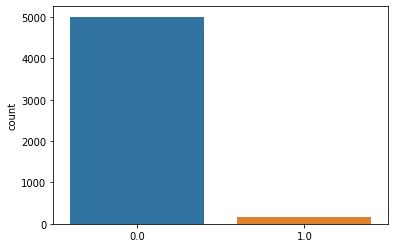

In [ ]:
# Make prediction on the test set
test_df = test_df[main_cols]
predictions = model.predict(test_df)

# Create a submission file
sub_file = ss.copy()
sub_file.predictions = predictions

# Check the distribution of your predictions
sns.countplot(sub_file.predictions);

In [ ]:
# Create a csv file and upload to zindi 
sub_file.to_csv('Baseline.csv', index = False)

###More Tips
- Thorough EDA and domain knowledge sourcing
- Re-group Categorical features 
- More Feature Engineering 
- Dataset balancing - oversampling, undersampling, SMOTE...
- Ensembling of models 
- Cross-validation: Group folds, Stratified...

# ******************* GOOD LUCK!!! ***************************